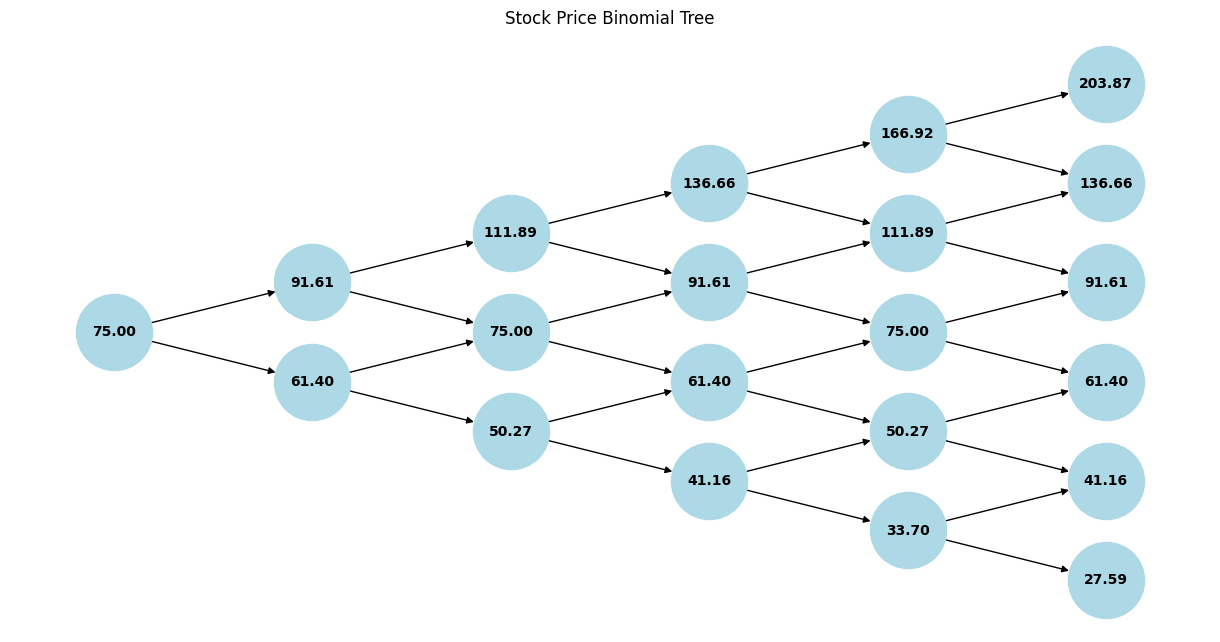

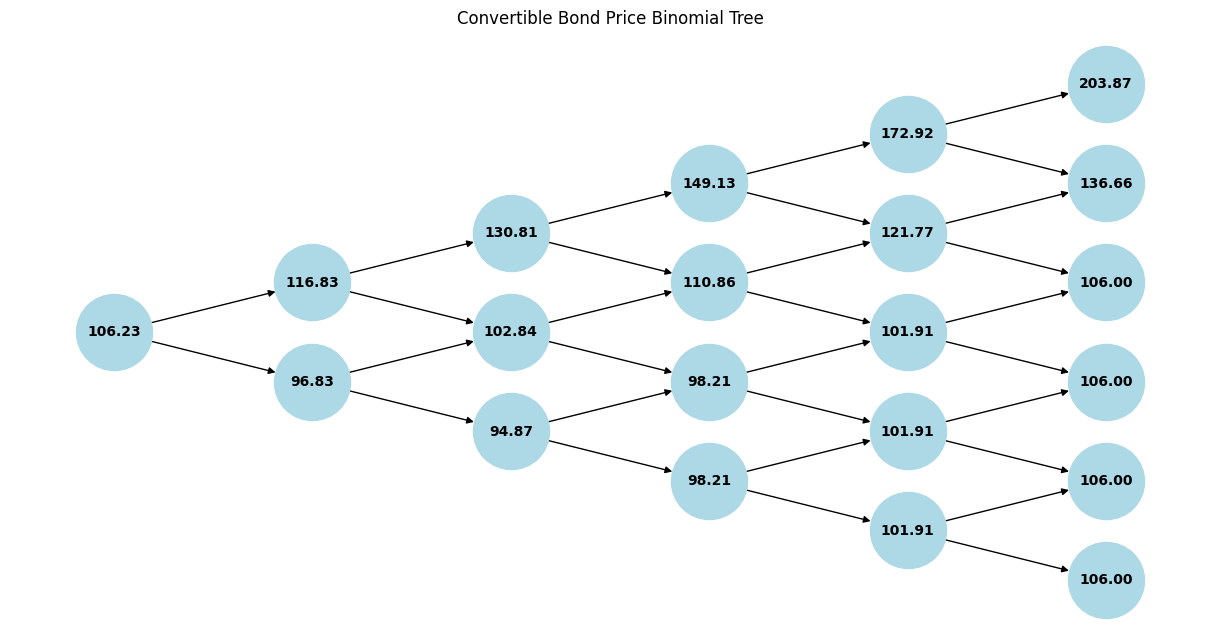

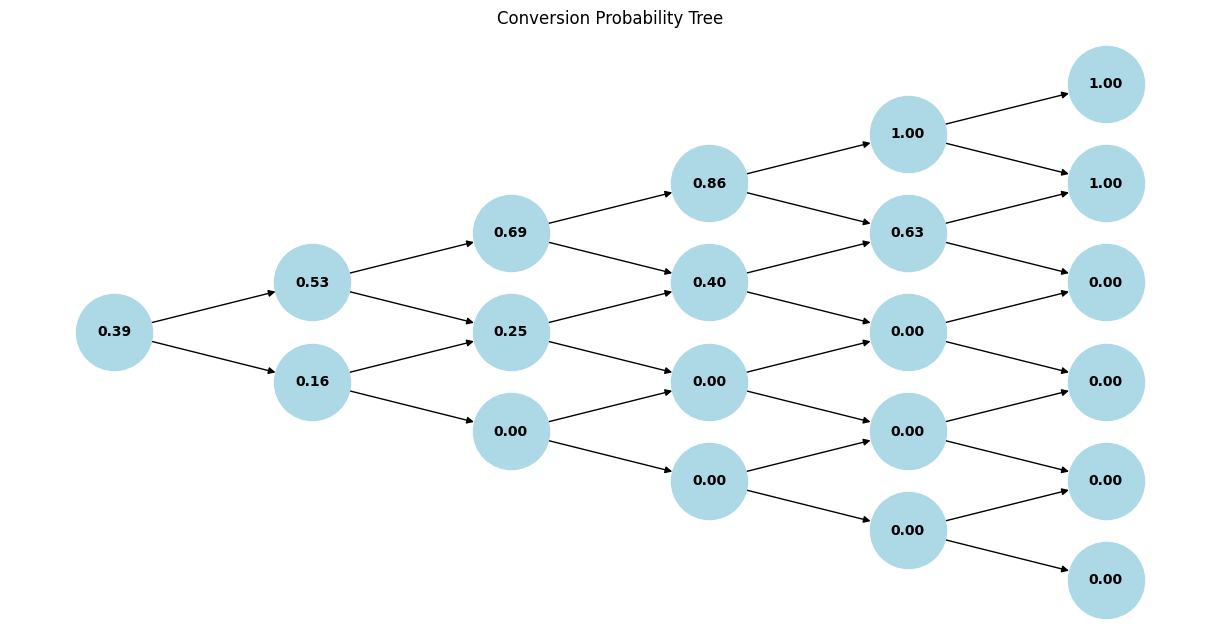

In [13]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Convertible bond pricing model (Cox-Ross-Rubinstein method)
def CRR_convertible_bond(S0, F, T, r, k, coupon, conversion_ratio, N, sigma, AmeEur='e'):
    # Time step
    dt = T / N
    u = np.exp(sigma * np.sqrt(dt))     # Up factor
    d = 1 / u                           # Down factor
    p = (np.exp(r * dt) - d) / (u - d)  # Risk-neutral probability

    # Create the binomial stock price tree
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Create the bond price tree (including coupon payments)
    BondPrice = np.zeros((N + 1, N + 1))
    # Create the conversion probability tree
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calculate bond prices and conversion probabilities at maturity
    for j in range(N + 1):
        stock_price = StockPrice[j, N]
        bond_value_at_maturity = max(conversion_ratio * stock_price, F + coupon)
        BondPrice[j, N] = bond_value_at_maturity
        # Conversion probability is 1 if conversion is optimal at maturity
        ConversionProbability[j, N] = 1 if conversion_ratio * stock_price > F + coupon else 0

    # Initialize coupon timing and time management
    CouponTime = T  # Initial coupon time matches maturity

    # Backward calculation for bond price and conversion probability
    for i in range(N - 1, -1, -1):
        if CouponTime != (T - np.ceil((N - i + 1) * dt)):
            CouponPayment = 1  # It's time to pay a coupon
            CouponTime = T - np.ceil((N - i) * dt)
            Time = CouponTime - dt * i
        else:
            CouponPayment = 0

        for j in range(i + 1):
            stock_price = StockPrice[j, i]

            # Dynamic discount factors (ru, rd)
            ru = ConversionProbability[j+1, i+1] * r + (1 - ConversionProbability[j+1, i+1]) * (r + k)
            rd = ConversionProbability[j, i+1] * r + (1 - ConversionProbability[j, i+1]) * (r + k)

            if CouponPayment == 1:
                CouponValue = coupon * (p * np.exp(-ru * Time) + (1 - p) * np.exp(-rd * Time))
            else:
                CouponValue = 0

            # Calculate bond price using backward induction
            hold_bond_value = CouponValue + p * BondPrice[j + 1, i + 1] * np.exp(-ru * dt) + (1 - p) * BondPrice[j, i + 1] * np.exp(-rd * dt)
            convert_to_stock_value = conversion_ratio * stock_price

            # Modify for American or European option style
            if AmeEur == 'a':
                # American style: check for early exercise
                BondPrice[j, i] = max(hold_bond_value, convert_to_stock_value)
            else:
                # European style: only exercise at maturity
                BondPrice[j, i] = hold_bond_value

            # Conversion probability: set to 1 if conversion happens, otherwise average the next nodes
            if BondPrice[j, i] == convert_to_stock_value and AmeEur == 'a':
                ConversionProbability[j, i] = 1
            else:
                ConversionProbability[j, i] = p * ConversionProbability[j + 1, i + 1] + (1 - p) * ConversionProbability[j, i + 1]

    return StockPrice, BondPrice, ConversionProbability

# Function to plot the binomial tree
def plot_binomial_tree(tree, title):
    steps = tree.shape[1] - 1
    G = nx.DiGraph()

    pos = {}
    labels = {}
    
    # Define the horizontal offset to center the nodes at each level
    for i in range(steps + 1):
        for j in range(i + 1):
            node = f"{i},{j}"
            G.add_node(node)
            pos[node] = (i, j - (i / 2))  # Adjust vertical position to center the tree
            labels[node] = f"{tree[j, i]:.2f}"

            if i < steps:
                G.add_edge(node, f"{i+1},{j}")
                G.add_edge(node, f"{i+1},{j+1}")

    # Plot
    plt.figure(figsize=(12, 6))
    nx.draw(G, pos, labels=labels, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold", edge_color="black")
    plt.title(title)
    plt.show()

# Parameters
S0 = 75                             # Initial stock price
F = 100                             # Face value of the bond
X = 100                             # Strike price for conversion
T = 5                               # Time to maturity (in years)
r = 0.07                            # Risk-free rate
q = 0
b = r - q
k = 0.03                            # Credit spread
sigma = 0.2                         # Volatility
dt = 1
coupon = 6                          # Coupon payment per year
m = 1                               # Conversion ratio (1 bond = 1 stock)
N = 5                               # Number of time steps
conversion_ratio = F / X            # Conversion ratio

# Calculate the binomial trees
StockPrice, BondPrice, ConversionProbability = CRR_convertible_bond(S0, F, T, r, k, coupon, m, N, sigma)

# Plot the stock price tree
plot_binomial_tree(StockPrice, "Stock Price Binomial Tree")

# Plot the bond price tree
plot_binomial_tree(BondPrice, "Convertible Bond Price Binomial Tree")

# Plot the conversion probability tree
plot_binomial_tree(ConversionProbability, "Conversion Probability Tree")


In [14]:

StockPrice, BondPrice, ConversionProbability = LatticeConvertibleBond(
    S0, F, T, r, k, coupon, conversion_ratio, N, model_type='Jarrow-Rudd'
)
OptionValue= BondPrice[0, 0]
print(f"Option value at t=0: {OptionValue}")


Option value at t=0: 108.15562831055445


In [40]:

def getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, N, model_type, drift=0):
    BondPrice, _ = LatticeConvertibleBond(S0, F, T, r, k, coupon, conversion_ratio, N, model_type, q=q, drift=drift)
    return BondPrice[0, 0]

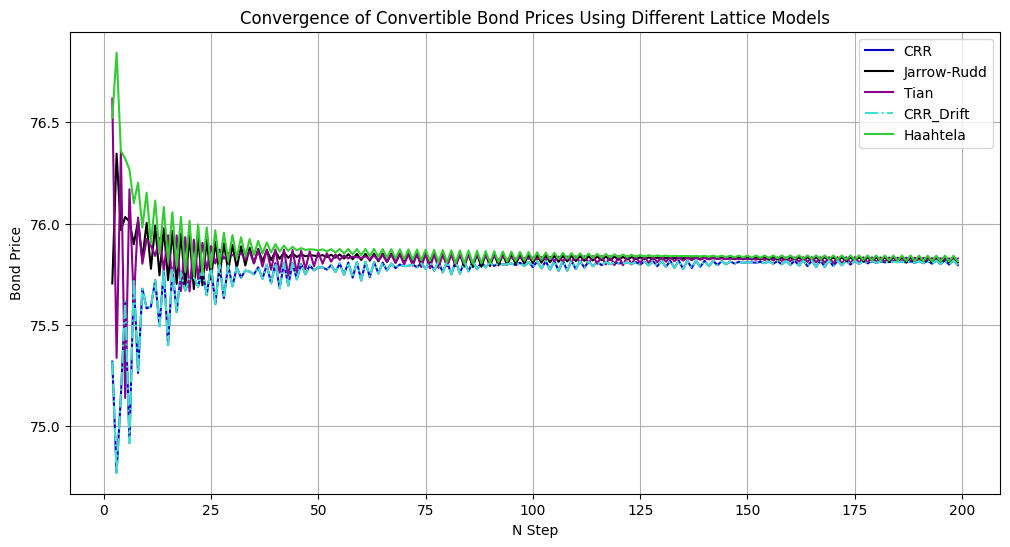

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Funzione per calcolare i parametri dell'albero binomiale
def calculate_tree_parameters(r, q, sigma, dt, model_type, drift=0):
    if model_type == 'CRR':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp(r * dt) - d) / (u - d)
    elif model_type == 'CRR_Drift':
        u = np.exp(sigma * np.sqrt(dt))
        d = 1 / u
        p = (np.exp((r + drift) * dt) - d) / (u - d)
    elif model_type == 'Jarrow-Rudd':
        u = np.exp((r - q - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt))
        d = np.exp((r - q - 0.5 * sigma ** 2) * dt - sigma * np.sqrt(dt))
        p = 0.5
    elif model_type == 'Tian':
        eta = np.exp(dt * sigma**2)
        u = 0.5 * np.exp(r * dt) * eta * (eta + 1 + np.sqrt(eta**2 + 2 * eta - 3))
        d = 0.5 * np.exp(r * dt) * eta * (eta + 1 - np.sqrt(eta**2 + 2 * eta - 3))
        p = (np.exp((r - q) * dt) - d) / (u - d)
    elif model_type == 'Haahtela':
        u = np.exp(r * dt) * (1 + np.sqrt(np.exp((sigma ** 2) * dt) - 1))
        d = np.exp(r * dt) * (1 - np.sqrt(np.exp((sigma ** 2) * dt) - 1))
        p = (np.exp((r - q) * dt) - d) / (u - d)
    else:
        raise ValueError("Unknown model type provided.")
    return u, d, p

# Funzione per calcolare il prezzo dell'obbligazione tramite l'albero binomiale
def getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, N, model_type, drift=0):
    dt = T / N
    u, d, p = calculate_tree_parameters(r, q, sigma, dt, model_type, drift)
    
    # Crea l'albero dei prezzi delle azioni
    StockPrice = np.zeros((N + 1, N + 1))
    for i in range(N + 1):
        for j in range(i + 1):
            StockPrice[j, i] = S0 * (u ** j) * (d ** (i - j))

    # Crea l'albero del prezzo dell'obbligazione
    BondPrice = np.zeros((N + 1, N + 1))
    ConversionProbability = np.zeros((N + 1, N + 1))

    # Calcola il valore dell'obbligazione alla scadenza
    for i in range(N + 1):
        BondPrice[i, N] = max(F + coupon, conversion_ratio * StockPrice[i, N])
        ConversionProbability[i, N] = 1 if BondPrice[i, N] == conversion_ratio * StockPrice[i, N] else 0

    # Calcolo a ritroso del valore dell'obbligazione e della probabilità di conversione
    for j in range(N - 1, -1, -1):
        for i in range(j + 1):
            # Calcola il valore attuale dell'obbligazione utilizzando le probabilità neutrali al rischio
            BondPrice[i, j] = np.exp(-(r + k) * dt) * (p * BondPrice[i + 1, j + 1] + (1 - p) * BondPrice[i, j + 1])
            ConversionProbability[i, j] = p * ConversionProbability[i + 1, j + 1] + (1 - p) * ConversionProbability[i, j + 1]

    return BondPrice[0, 0]

# Parametri di input
S0 = 75
F = 100
X = 100
T = 5
r = 0.07
k = 0.03
sigma = 0.2
q = 0
coupon = 6
conversion_ratio = F / X
min_step = 2
max_step = 200

# Definire i modelli
model_types = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela']

# Inizializza un dizionario per memorizzare i prezzi per ciascun modello
results = {model: np.zeros([max_step - min_step]) for model in model_types}

# Loop attraverso ciascun modello e calcola il prezzo dell'obbligazione per diversi step
for model in model_types:
    j = 0
    for i in np.arange(min_step, max_step):
        results[model][j] = getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model, drift=0)
        j += 1

# Tracciare tutti i modelli nello stesso grafico
plt.figure(figsize=(12, 6))

# Definire un set di colori e stili per ciascun modello
styles = {
    'CRR': {'color': 'mediumblue', 'linestyle': '-'},
    'Jarrow-Rudd': {'color': 'black', 'linestyle': '-'},
    'Tian': {'color': 'darkmagenta', 'linestyle': '-'},
    'CRR_Drift': {'color': 'turquoise', 'linestyle': '-.'},
    'Haahtela': {'color': 'limegreen', 'linestyle': '-'}
}

# Traccia ogni modello con il colore e lo stile rispettivi
for model in model_types:
    plt.plot(range(min_step, max_step), results[model], label=model, color=styles[model]['color'], linestyle=styles[model]['linestyle'])

# Aggiungi etichette e titolo
plt.xlabel("N Step")
plt.ylabel("Bond Price")
plt.title("Convergence of Convertible Bond Prices Using Different Lattice Models")
plt.legend()
plt.grid(True)
plt.show()


Convergence analysis CRR  

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='CRR'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model_type, drift=0)
  j=j+1

# plt.plot(UROBORO) #una bella chopped convergence
plt.plot(UROBORO, color="red", linestyle="-", linewidth=1)


Convergence analysis Tian

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='Jarrow-Rudd'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model_type, drift=0)
  j=j+1

plt.plot(UROBORO, color="blue", linestyle="-", linewidth=1)

Convergence analysis Tian

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='Tian'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model_type, drift=0)
  j=j+1
  plt.figure(figsize=(12, 6))

plt.plot(UROBORO, color="black", linestyle="-", linewidth=1)

Convergence analysis CRR_Drift

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='CRR_Drift'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model_type, drift=0)
  j=j+1

plt.plot(UROBORO, color="magenta", linestyle="-", linewidth=1)

convergence analysis Haahtela

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='Haahtela'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model_type, drift=0)
  j=j+1
  plt.figure(figsize=(12, 6))

plt.plot(UROBORO, color="green", linestyle="-", linewidth=1)

Convergence analysis EQP

In [ ]:
# Input parameters
S0 = 75           # Initial stock price
F = 100           # Face value of the bond
X = 100           # Strike price for conversion
T = 5             # Time to maturity in years
r = 0.07          # Risk-free rate
sigma = 0.2       # Volatility
q = 0             # Dividend yield
coupon = 6        # Annual coupon payment
CRatio = F / X    # Conversion ratio
min_step = 2
max_step = 700       # Number of steps in the tree
model_type='EQP'

UROBORO = np.zeros([max_step-min_step])
j=0
for i in np.arange(min_step,max_step):
  UROBORO[j]=getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, conversion_ratio, i, model_type, drift=0)
  j=j+1
  plt.figure(figsize=(12, 6))

plt.plot(UROBORO, color="pink", linestyle="-", linewidth=1)

In [ ]:
min_step = 2
max_step = 100    # Number of steps in the tree

# Define the list of models to include
model_types = ['CRR', 'Jarrow-Rudd', 'Tian', 'CRR_Drift', 'Haahtela', 'EQP']

# Initialize a dictionary to store the prices for each model
results = {model: np.zeros([max_step - min_step]) for model in model_types}

# Loop through each model and calculate the bond price for varying steps
for model in model_types:
    j = 0
    for i in np.arange(min_step, max_step):
        results[model][j] = getPrice_LatticeModel(S0, F, T, r, k, sigma, q, coupon, CRatio, i, model, drift=0)
        j += 1

# Plotting all models on the same graph with different styles and colors
plt.figure(figsize=(10, 6))

# Define a color and line style scheme for each model
styles = {
    'CRR': {'color': 'black', 'linestyle': '-'},
    'Jarrow-Rudd': {'color': 'blue', 'linestyle': '-'},
    'Tian': {'color': 'green', 'linestyle': '-'},
    'CRR_Drift': {'color': 'magenta', 'linestyle': '-'},
    'Haahtela': {'color': 'red', 'linestyle': '-'},
    'EQP': {'color': 'pink', 'linestyle': '-'}
}

# Plot each model with its respective color and style
for model in model_types:
    plt.plot(range(min_step, max_step), results[model], label=model, color=styles[model]['color'], linestyle=styles[model]['linestyle'])

# Customize the plot
plt.xlabel("N Step", fontsize=12)
plt.ylabel("Option Price", fontsize=12)
plt.title("Option Price Convergence for Different Models", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True)
plt.show()
